In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, GaussianDropout, GlobalAveragePooling2D, MaxPooling2D,DepthwiseConv2D
from keras.models import Sequential, load_model
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import os
from PIL import Image
import os
import shutil
import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
import keras
from keras.optimizers import Adam
import os
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import pickle

# Assuming 'history' is your model's training history
from tensorflow.keras.models import load_model, save_model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unrar x "/content/drive/MyDrive/Untitled Folder/NN_HW2_Face_Emotion.rar" "/content/FER/"


In [7]:

# Define the paths to your dataset
train_data_dir = '/content/FER/TRAIN'
Tune_dir = '/content/FER/TUNE'

# Define the ImageDataGenerator for training set with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

# Define the ImageDataGenerator for validation set (no augmentation)

# Define batch size and image size
batch_size = 400
image_size = (128, 128)  # Adjust this based on your image dimensions

# Generate the training set
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training' # Adjust if using different classification settings
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'# Adjust if using different classification settings
)

Tune_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

# Generate the validation set
Tune_generator = Tune_datagen.flow_from_directory(
    Tune_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'  # Adjust if using different classification settings
)


Found 6400 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.


In [8]:
import tensorflow as tf
import keras
train_data_dir = '/content/FER/TRAIN'
Tune_dir = '/content/FER/TUNE'
train_ds = tf.keras.utils.image_dataset_from_directory(
directory =train_data_dir,
image_size = (128, 128),
validation_split = 0.15,
subset = "training",
seed = 42,
shuffle = True)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_data_dir,
    image_size=(128, 128),
    validation_split=0.15,
    subset="validation",
    seed=42,
    shuffle=True
)
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
validation_ds = validation_ds.map(lambda x, y: (x / 255.0, y))

Found 8000 files belonging to 8 classes.
Using 6800 files for training.
Found 8000 files belonging to 8 classes.
Using 1200 files for validation.


In [9]:
tune_ds = tf.keras.utils.image_dataset_from_directory(
    directory=Tune_dir,
    image_size=(128, 128),
    seed=42,
    shuffle=True
)
tune_ds = tune_ds.map(lambda x, y: (x / 255.0, y))

Found 1600 files belonging to 8 classes.


Certainly! Here's a concise text cell for the provided MobileNet-like architecture in a code cell:

---

# MobileNet

This code cell defines a MobileNet-inspired architecture using depthwise separable convolutions. It constructs a Sequential model comprising multiple depthwise convolutional blocks and ends with a Global Average Pooling layer followed by a Dense layer for classification. Key components include:

- **Depthwise Convolution Blocks:** Utilized for feature extraction, these blocks consist of depthwise separable convolutions followed by batch normalization and ReLU activation.
- **Strided Convolutions:** Employed at intervals for downsampling the feature maps.
- **Model Scaling:** The `alpha` parameter scales the width of the network channels.
- **Dropout (Commented Out):** A dropout layer (currently commented out) is provided for regularization but remains inactive in the current configuration.
- **Output Layer:** A Dense layer with a softmax activation, producing predictions across 8 classes.

The architecture emphasizes lightweight depthwise convolutions, reducing computational complexity while maintaining expressive power, suitable for mobile and resource-constrained environments.

---

In [10]:
def depth_conv_block(model, d, k, s):
  model.add(DepthwiseConv2D((k, k), strides=(s, s), padding='same', use_bias=False))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(d, (1, 1), padding='same', use_bias=False))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  return model

model = Sequential()
alpha = 1
dropout=0.3
# CONV
model.add(Conv2D(int(32 * alpha), (3, 3), padding='same', use_bias=False, strides=(2, 2), input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
# DEPTHWISE CONVS
model = depth_conv_block(model, int(64 * alpha), 3, 1)

model = depth_conv_block(model, int(128 * alpha), 3, 2)
model = depth_conv_block(model, int(128 * alpha), 3, 1)

model = depth_conv_block(model, int(256 * alpha), 3, 2)
model = depth_conv_block(model, int(256 * alpha), 3, 1)

model = depth_conv_block(model, int(512 * alpha), 3, 2)
model = depth_conv_block(model, int(512 * alpha), 3, 1)
model = depth_conv_block(model, int(512 * alpha), 3, 1)
model = depth_conv_block(model, int(512 * alpha), 3, 1)
model = depth_conv_block(model, int(512 * alpha), 3, 1)
model = depth_conv_block(model, int(512 * alpha), 3, 1)

model = depth_conv_block(model, int(1024 * alpha), 3, 2)
model = depth_conv_block(model, int(1024 * alpha), 3, 1)
# FLATTEN
model.add(GlobalAveragePooling2D())
#model.add(Dropout(dropout))
model.add(Dense(8, activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        864       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 depthwise_conv2d (Depthwis  (None, 64, 64, 32)        288       
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 32)        128       
 chNormalization)                                                
                                                        

In [12]:
# Compile the model

batch_size=32
epochs=25
from keras.optimizers import Adam
# from tensorflow.python.keras.optimizer_v2 import adam as adam_v2
batch_size=32
epoch=50

optimizer = keras.optimizers.Adam(learning_rate=0.006)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

# Train the model
train_history = model.fit(
    train_ds,
    batch_size=32,
    epochs=epochs,validation_data=validation_ds
)

Epoch 1/25
213/213 [==============================] - 38s 59ms/step - loss: 2.0291 - accuracy: 0.1932 - val_loss: 2.1639 - val_accuracy: 0.1275
Epoch 2/25
213/213 [==============================] - 10s 48ms/step - loss: 1.6888 - accuracy: 0.2779 - val_loss: 2.5416 - val_accuracy: 0.1275
Epoch 3/25
213/213 [==============================] - 11s 52ms/step - loss: 1.6050 - accuracy: 0.3207 - val_loss: 1.8161 - val_accuracy: 0.1858
Epoch 4/25
213/213 [==============================] - 12s 54ms/step - loss: 1.5002 - accuracy: 0.3835 - val_loss: 1.7562 - val_accuracy: 0.3392
Epoch 5/25
213/213 [==============================] - 12s 55ms/step - loss: 1.3955 - accuracy: 0.4324 - val_loss: 1.5366 - val_accuracy: 0.4008
Epoch 6/25
213/213 [==============================] - 10s 49ms/step - loss: 1.3191 - accuracy: 0.4684 - val_loss: 1.6138 - val_accuracy: 0.3958
Epoch 7/25
213/213 [==============================] - 11s 53ms/step - loss: 1.2698 - accuracy: 0.4979 - val_loss: 1.6988 - val_accuracy:

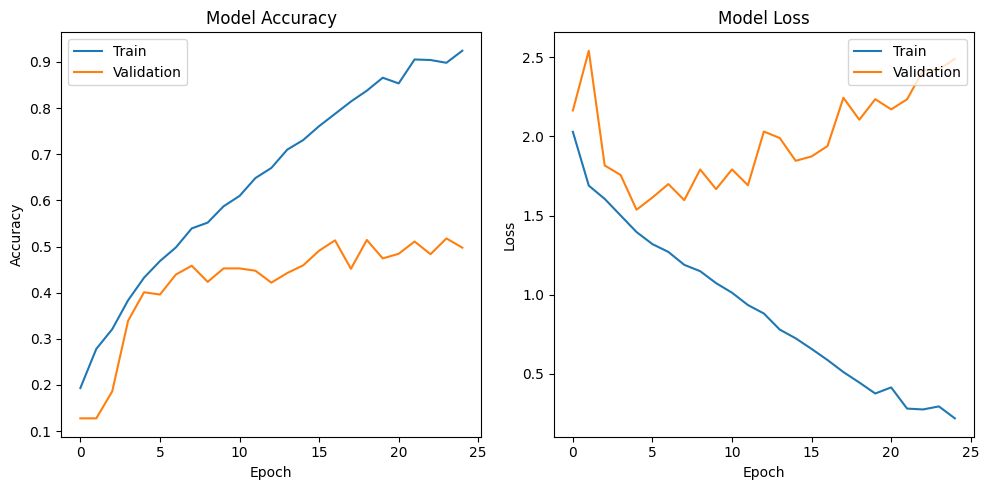

In [13]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(train_ds, test_ds, model):
    try:
        # Evaluate the model
        test_loss, test_acc = model.evaluate(test_ds)
        train_loss, train_acc = model.evaluate(train_ds)

        # Get predictions
        train_predictions = np.argmax(model.predict(train_ds), axis=-1)
        test_predictions = np.argmax(model.predict(test_ds), axis=-1)

        # Get true labels
        train_true_labels = np.concatenate([labels.numpy() for _, labels in train_ds])
        test_true_labels = np.concatenate([labels.numpy() for _, labels in test_ds])

        # Calculate confusion matrices
        train_cm = confusion_matrix(train_true_labels, train_predictions)
        test_cm = confusion_matrix(test_true_labels, test_predictions)

        # Print classification reports
        print("\nClassification Report for train:")
        print(classification_report(train_true_labels, train_predictions))

        # For each class, calculate specificity
        train_specificity = [train_cm[i, i] / sum(train_cm[i, :]) for i in range(train_cm.shape[0])]
        print("Train's Specificity:", train_specificity)

        print("\nClassification Report for test:")
        print(classification_report(test_true_labels, test_predictions))

        # For each class, calculate specificity
        test_specificity = [test_cm[i, i] / sum(test_cm[i, :]) for i in range(test_cm.shape[0])]
        print("Test's Specificity:", test_specificity)

        # Plot confusion matrices
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        sns.heatmap(train_cm, annot=True, cmap='Blues', fmt='g',
                    xticklabels=list(range(8)),
                    yticklabels=list(range(8)), ax=axes[0])
        axes[0].set_title('Train Confusion Matrix')
        axes[0].set_xlabel('Predicted')
        axes[0].set_ylabel('Actual')

        sns.heatmap(test_cm, annot=True, cmap='Blues', fmt='g',
                    xticklabels=list(range(8)),
                    yticklabels=list(range(8)), ax=axes[1])
        axes[1].set_title('Test Confusion Matrix')
        axes[1].set_xlabel('Predicted')
        axes[1].set_ylabel('Actual')

        plt.tight_layout()
        plt.show()

        return test_acc, test_loss, train_acc, train_loss

    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None, None, None


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
directory =train_data_dir,
image_size = (128, 128),
validation_split = 0.15,
subset = "training",
seed = 42,
shuffle = False)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_data_dir,
    image_size=(128, 128),
    validation_split=0.15,
    subset="validation",
    seed=42,
    shuffle=False
)
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
validation_ds = validation_ds.map(lambda x, y: (x / 255.0, y))

Found 8000 files belonging to 8 classes.
Using 6800 files for training.
Found 8000 files belonging to 8 classes.
Using 1200 files for validation.


In [16]:
validation_ds.shuffle=False
train_ds.shuffle=False

In [20]:
import numpy as np
model.evaluate(train_ds)
model.evaluate(validation_ds)

38/38 [==============================] - 1s 17ms/step - loss: 2.4902 - accuracy: 0.4975


[2.4901773929595947, 0.4975000023841858]

# Tune

In [21]:

batch_size=400
epoch=25
# Train the model
tune_history = model.fit(
    tune_ds,
    epochs=epoch,validation_data=validation_ds
)

Epoch 1/25
50/50 [==============================] - 3s 56ms/step - loss: 2.1107 - accuracy: 0.3506 - val_loss: 2.8860 - val_accuracy: 0.3367
Epoch 2/25
50/50 [==============================] - 4s 73ms/step - loss: 0.8342 - accuracy: 0.7406 - val_loss: 1.7023 - val_accuracy: 0.4225
Epoch 3/25
50/50 [==============================] - 4s 82ms/step - loss: 0.1424 - accuracy: 0.9744 - val_loss: 1.8775 - val_accuracy: 0.4167
Epoch 4/25
50/50 [==============================] - 3s 65ms/step - loss: 0.0289 - accuracy: 0.9962 - val_loss: 2.0154 - val_accuracy: 0.4342
Epoch 5/25
50/50 [==============================] - 3s 55ms/step - loss: 0.0112 - accuracy: 0.9987 - val_loss: 1.9658 - val_accuracy: 0.4617
Epoch 6/25
50/50 [==============================] - 4s 73ms/step - loss: 0.0120 - accuracy: 0.9981 - val_loss: 2.0535 - val_accuracy: 0.4592
Epoch 7/25
50/50 [==============================] - 3s 68ms/step - loss: 0.0071 - accuracy: 0.9987 - val_loss: 2.1034 - val_accuracy: 0.4633
Epoch 8/25
50

In [ ]:
import json
model.save('/content/drive/MyDrive/Untitled Folder/tuned_VGGNet_50_epoch.h5')
history_json = json.dumps(tune_history.history)
# Save the history to a file
with open('/content/drive/MyDrive/Untitled Folder/tuned_history_VGGNet_50.json', 'w') as json_file:
    json_file.write(history_json)

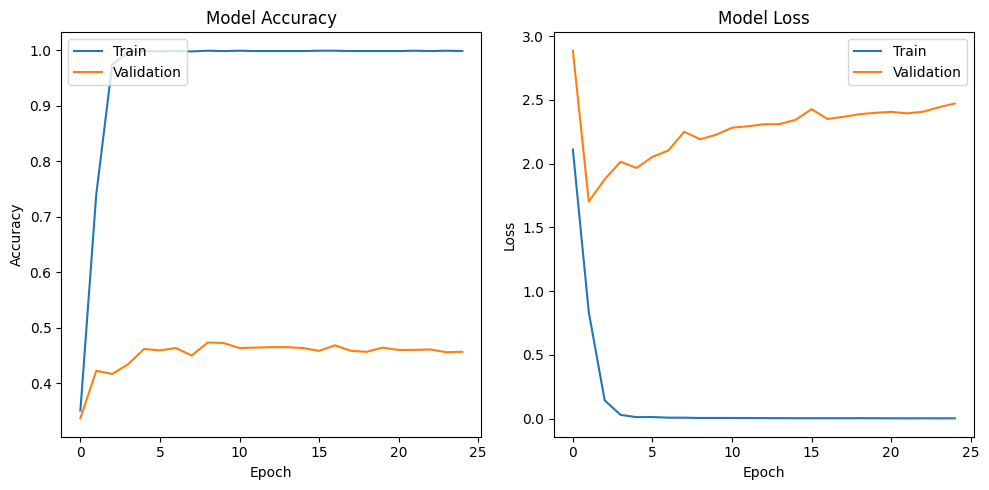

In [22]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(tune_history.history['accuracy'])
plt.plot(tune_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(tune_history.history['loss'])
plt.plot(tune_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [23]:
import numpy as np
model.evaluate(train_ds)
model.evaluate(validation_ds)

38/38 [==============================] - 1s 16ms/step - loss: 2.4718 - accuracy: 0.4567


[2.471771240234375, 0.4566666781902313]